In [1]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.image_classification.models.extraction import ExtractionFeatureExtractor
from torchlake.common.utils.image import load_image
from torchlake.object_detection.constants.schema import DetectorContext
from torchlake.common.datasets.voc import VOCDetectionFromCSV
from torchlake.object_detection.models.yolov1 import YOLOV1, YOLOLoss
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.object_detection.utils.plot import draw_pred
from torchlake.object_detection.utils.train import collate_fn
from torchlake.common.controller.trainer import DoNothingTrainer

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import random
from pathlib import Path

# setting

In [3]:
artifact_path = Path('../../artifacts/yolov1/extraction')
artifact_path.mkdir(exist_ok=True)

In [4]:
data_path = Path("../../data/VOCdevkit")

In [5]:
NUM_CLASS = len(VOC_CLASS_NAMES)
NUM_ANCHORS = 2

In [6]:
CONTEXT = DetectorContext(
    detector_name="yolov1",
    dataset="VOC",
    device="cuda:0",
    num_classes=NUM_CLASS,
    num_anchors=NUM_ANCHORS,
)

# data

In [7]:
BATCH_SIZE = 16

In [8]:
IMAGE_SIZE = 448

In [9]:
transform = A.Compose(
    [
        # A.ColorJitter(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5, rotate_limit=0),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # A.augmentations.geometric.resize.SmallestMaxSize(input_size),
        # A.RandomSizedBBoxSafeCrop(input_size, input_size),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [10]:
train_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_trainval.csv"),
    transform=transform,
)

In [11]:
for x, y in train_dataset:
    print(x.shape, len(y))
    break

torch.Size([3, 448, 448]) 1


In [12]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [13]:
for x, y in train_loader:
    print(x.shape, len(y))
    break

torch.Size([16, 3, 448, 448]) 16


# model

In [14]:
weight_path = Path("../../artifacts/extraction/extraction.pth")
backbone = ExtractionFeatureExtractor("block", weight_path, trainable=True)
backbone.fix_target_layers(["2_1"])

In [15]:
model = YOLOV1(backbone, CONTEXT).to(CONTEXT.device)

In [16]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
YOLOV1                                                  --
├─ExtractionFeatureExtractor: 1-1                       --
│    └─Extraction: 2-1                                  --
│    │    └─Sequential: 3-1                             120,512
│    │    └─Sequential: 3-2                             22,291,712
│    │    └─Sequential: 3-3                             --
├─Sequential: 1-2                                       --
│    └─Conv2dNormActivation: 2-2                        --
│    │    └─Conv2d: 3-4                                 9,437,184
│    │    └─BatchNorm2d: 3-5                            2,048
│    │    └─LeakyReLU: 3-6                              --
│    └─Conv2dNormActivation: 2-3                        --
│    │    └─Conv2d: 3-7                                 9,437,184
│    │    └─BatchNorm2d: 3-8                            2,048
│    │    └─LeakyReLU: 3-9                              --
│    └─Conv2dNormA

# train

In [17]:
EPOCH = 10

In [18]:
trainer = DoNothingTrainer(EPOCH, CONTEXT.device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = YOLOLoss(CONTEXT, lambda_coord=5, lambda_noobject=0.5)

In [20]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [21]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

100%|██████████| 1034/1034 [04:57<00:00,  3.48it/s]


epoch 1 : 0.0006438199204628714


100%|██████████| 1034/1034 [04:51<00:00,  3.55it/s]


epoch 2 : 0.0005464355344602629


100%|██████████| 1034/1034 [04:50<00:00,  3.56it/s]


epoch 3 : 0.000534857510663596


100%|██████████| 1034/1034 [04:50<00:00,  3.56it/s]


epoch 4 : 0.000531540586033519


100%|██████████| 1034/1034 [04:48<00:00,  3.58it/s]


epoch 5 : 0.0005308203517116617


100%|██████████| 1034/1034 [04:54<00:00,  3.51it/s]


epoch 6 : 0.0005132276220319205


100%|██████████| 1034/1034 [04:56<00:00,  3.49it/s]


epoch 7 : 0.0005083123018041458


100%|██████████| 1034/1034 [04:56<00:00,  3.49it/s]


epoch 8 : 0.000505004477412692


100%|██████████| 1034/1034 [04:47<00:00,  3.60it/s]


epoch 9 : 0.0004998492999364869


100%|██████████| 1034/1034 [04:55<00:00,  3.50it/s]

epoch 10 : 0.0004975945107045276


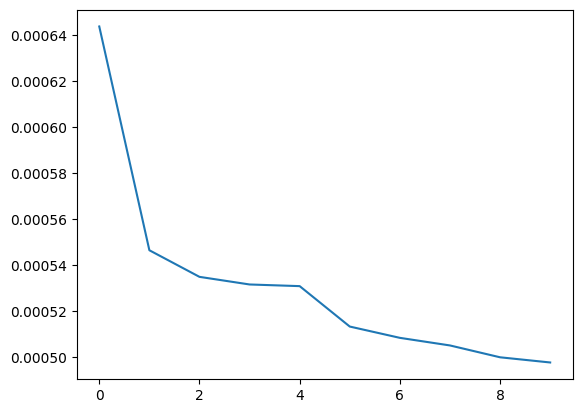

In [22]:
plt.plot(training_loss)

In [23]:
model_path = artifact_path / f'yolov1.{backbone.network_name}.jointly_train.10.pth'

In [24]:
torch.save(model.state_dict(), model_path)

In [78]:
get_file_size(model_path)

'240.13MiB'

In [ ]:
model.load_state_dict(torch.load(model_path.as_posix()))

# inference

In [25]:
from tqdm import tqdm
from torchlake.object_detection.models.yolov1.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor

In [26]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.1, NMS_THRESH=0.5)

In [27]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [28]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [29]:
import numpy as np
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import rand_color_map, plot_grids

In [30]:
color_map = rand_color_map(VOC_CLASS_NAMES)

In [31]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [32]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [33]:
model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(CONTEXT.device)

        # B, C+1, H, W
        output = predictor.detect_image(model, img, is_batch=True)
        break

  0%|          | 0/309 [00:00<?, ?it/s]


In [34]:
placeholder = []
for im, o in zip(img, output):
    overlay = img_tensor_to_np(im, 255, np.uint8)
    draw_pred(
        overlay,
        o,
        class_names=VOC_CLASS_NAMES,
        class_colors=color_map,
    )
    placeholder.append(overlay)

aeroplane: 0.17
person: 0.11
aeroplane: 0.21
aeroplane: 0.13
person: 0.11
person: 0.18
person: 0.10
person: 0.10


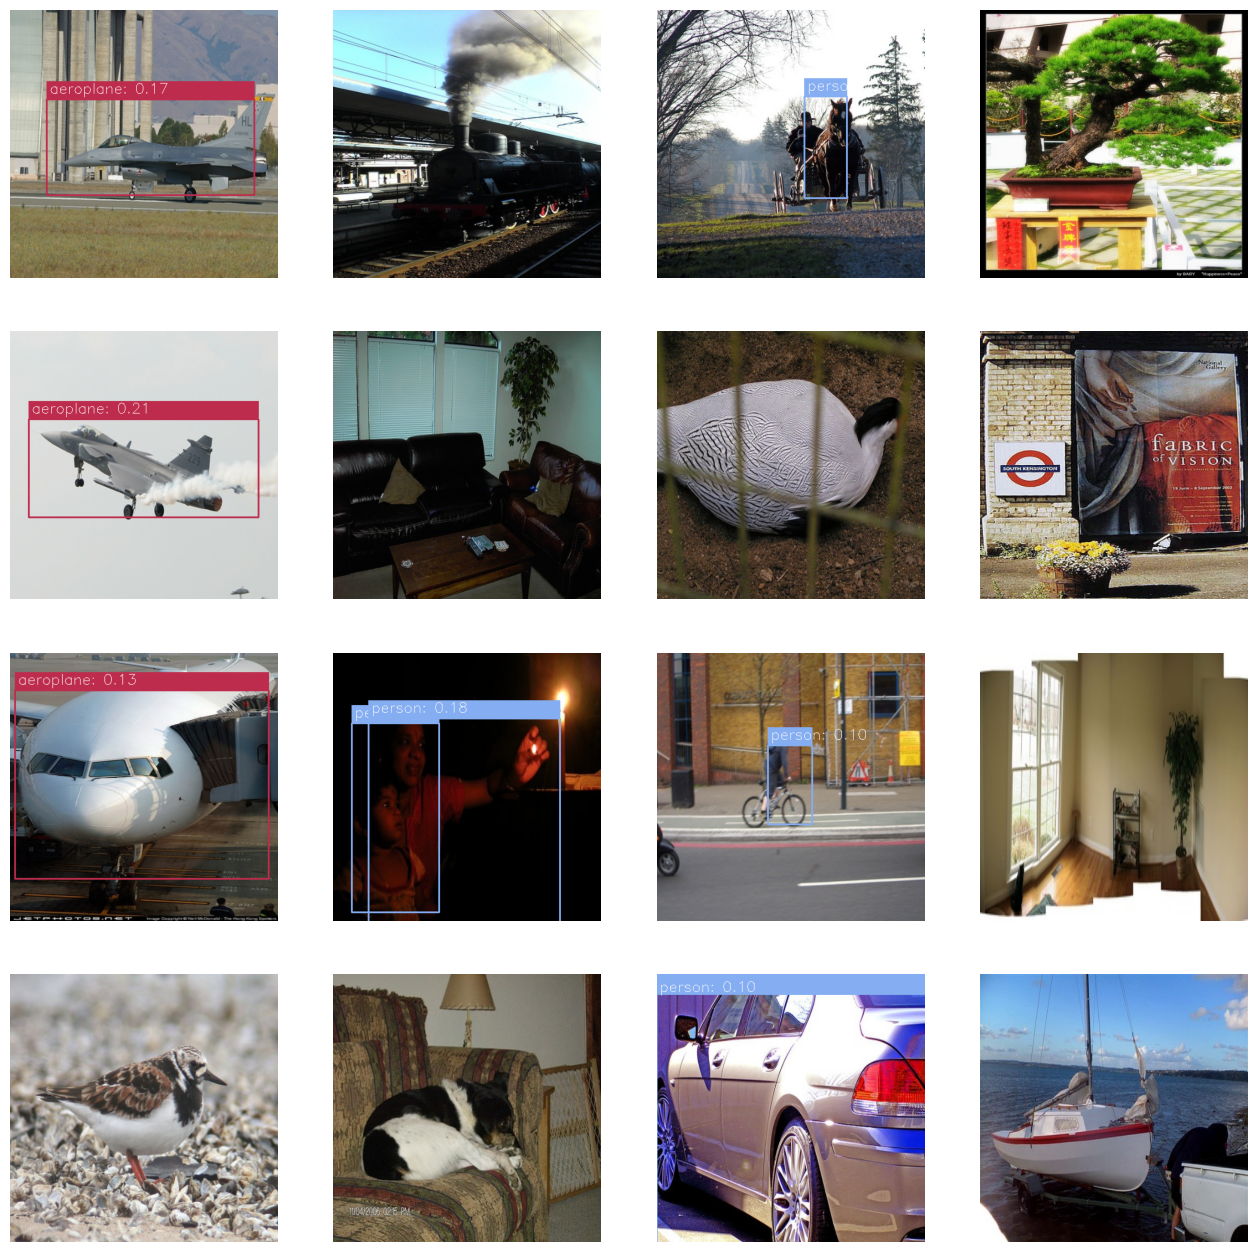

In [35]:
plot_grids(
    placeholder[:16],
    num_row=4,
    num_col=4,
    figsize=(16,16),
)

In [ ]:
humans_img = "D://W/gf/1672998424399.jpg"
human_img = "D://W/hmm/Screenshot_20240612_091521.jpg"
obj_img = "D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"

predictor.predict_image_file(
    model,
    [humans_img, human_img, obj_img],
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.41
person: 0.50
D://W/gf/1672998424399.jpg 2
person: 0.24
D://W/hmm/Screenshot_20240612_091521.jpg 1
aeroplane: 0.39
D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg 1


In [ ]:
predictor.predict_video_file(
    model,
    "../../data/movie.mp4",
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.25
person: 0.23
person: 0.24
person: 0.22
person: 0.25
person: 0.24
person: 0.22
person: 0.20
person: 0.23
person: 0.21
person: 0.26
person: 0.25
person: 0.22
person: 0.23
person: 0.27
person: 0.30
person: 0.29
person: 0.29
person: 0.10
person: 0.15
person: 0.15
person: 0.19
person: 0.18
person: 0.23
person: 0.24
person: 0.16
person: 0.11
person: 0.11
person: 0.12
person: 0.11
person: 0.13
person: 0.10
person: 0.12
person: 0.12
person: 0.11
person: 0.22
person: 0.21
person: 0.20
person: 0.18
person: 0.20
person: 0.24
person: 0.26
person: 0.27
person: 0.27
person: 0.26
person: 0.24
person: 0.27
person: 0.22
person: 0.22
person: 0.22
person: 0.22
person: 0.22
person: 0.22
person: 0.21
person: 0.21
person: 0.20
person: 0.21
person: 0.20
person: 0.19
person: 0.19
person: 0.21
person: 0.22
person: 0.22
person: 0.25
person: 0.28
person: 0.27
person: 0.31
person: 0.30
person: 0.30
person: 0.28
person: 0.29
person: 0.30
person: 0.29
person: 0.27
person: 0.28
person: 0.28
person: 0.29

# evaluation

In [36]:
from torchlake.object_detection.models.yolov1.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor
from torchlake.object_detection.controller.evaluator import Evaluator

In [37]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.1, NMS_THRESH=0.5)

In [38]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [39]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [40]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [41]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [42]:
evaluator = Evaluator(CONTEXT)

In [43]:
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 309/309 [01:35<00:00,  3.24it/s]

       aeroplane  bicycle      bird      boat    bottle       bus       car  \
AP@0.5  0.234182  0.14795  0.090909  0.090909  0.090909  0.090909  0.090909   

             cat     chair       cow  ...       dog     horse motorbike  \
AP@0.5  0.152545  0.090909  0.090909  ...  0.090909  0.090909  0.090909   

          person pottedplant    sheep      sofa     train tvmonitor       all  
AP@0.5  0.212236    0.208588  0.15812  0.157517  0.156772  0.155974  0.129194  

[1 rows x 21 columns]


In [44]:
result_table.T

,AP@0.5
aeroplane,0.234182
bicycle,0.14795
bird,0.090909
boat,0.090909
bottle,0.090909
bus,0.090909
car,0.090909
cat,0.152545
chair,0.090909
cow,0.090909


In [ ]:
for path in artifact_path.joinpath(evaluator.cfg.MODEL.BACKBONE).glob("*.pth"):
    model.load_state_dict(torch.load(path))

    evaluator.run(
        predictor,
        model,
        test_loader,
        VOC_CLASS_NAMES,
        save_dir=artifact_path.as_posix(),
        output_filename=f"{path.stem}.eval.csv",
    )